## Performing Clean-up and Analysis on Native Ad Data Scraped "From Around the Web"

In [1]:
import pandas as pd
from datetime import datetime
import dateutil
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
import re
from urllib.parse import urlparse
import json

### Data Load and Cleaning

In [2]:
data = pd.read_csv('../data/in/native_ad_data.csv')

In [3]:
data.head()

,_id,headline,link,img,provider,source,img_file,date,final_link,orig_article
0,ObjectId(58d90ce706e10d04f7e1b3d8),20 Cool Moments From Joe Biden’s Time In Office,http://scribol.com/a/news-and-politics/ways-jo...,https://console.brax-cdn.com/creatives/98c6400...,taboola,http://tmz.com,./imgs/876aa5e83f6fb81a81908db3c02fdcc00d44400...,2017-03-27T12:59:09.279Z,http://scribol.com/a/news-and-politics/ways-jo...,NaN
1,ObjectId(58d90ce706e10d04f7e1b3d9),Troubled News Anchor Does The Unthinkable On Air,http://www.trend-chaser.com/entertainment/the-...,https://console.brax-cdn.com/creatives/b86bbc0...,taboola,http://tmz.com,./imgs/bab1037467f1385cd865c48029db808b03a151d...,2017-03-27T12:59:09.819Z,http://www.trend-chaser.com/entertainment/the-...,NaN
2,ObjectId(58d90ce706e10d04f7e1b3da),It's Almost Hard To Fathom What He look's Like...,http://www.journalistate.com/popular/big-holly...,http://cdn.taboolasyndication.com/libtrc/stati...,taboola,http://tmz.com,./imgs/feeb5be5a9758fcca8cef21b6fb842ccc839476...,2017-03-27T12:59:10.750Z,http://www.journalistate.com/popular/big-holly...,NaN
3,ObjectId(58d90ce706e10d04f7e1b3db),Troubled News Anchor Does The Unthinkable On Air,http://www.trend-chaser.com/entertainment/the-...,https://console.brax-cdn.com/creatives/b86bbc0...,taboola,http://tmz.com,./imgs/bab1037467f1385cd865c48029db808b03a151d...,2017-03-27T12:59:11.430Z,http://www.trend-chaser.com/entertainment/the-...,NaN
4,ObjectId(58d90ce706e10d04f7e1b3dc),Try NOT Gasp When You See Who Queen Latifah Is...,http://zcretuzft.iflmylife.com/entertainment/o...,http://cdn.taboolasyndication.com/libtrc/stati...,taboola,http://tmz.com,./imgs/d75401b962746864063b51f164633ffeb93931d...,2017-03-27T12:59:11.510Z,http://www.iflmylife.com/entertainment/other-h...,NaN


As a side note, the headlines from zergnet all have some newlines we need to get rid of and they appear to have concatenated the headline with the provider. So let's clean those up.

In [4]:
data['headline'] = data['headline'].apply(lambda x: re.sub('(?<=[a-z])\.?([A-Z](.*))' , '', x.strip()))
data.head()

,_id,headline,link,img,provider,source,img_file,date,final_link,orig_article
0,ObjectId(58d90ce706e10d04f7e1b3d8),20 Cool Moments From Joe Biden’s Time In Office,http://scribol.com/a/news-and-politics/ways-jo...,https://console.brax-cdn.com/creatives/98c6400...,taboola,http://tmz.com,./imgs/876aa5e83f6fb81a81908db3c02fdcc00d44400...,2017-03-27T12:59:09.279Z,http://scribol.com/a/news-and-politics/ways-jo...,NaN
1,ObjectId(58d90ce706e10d04f7e1b3d9),Troubled News Anchor Does The Unthinkable On Air,http://www.trend-chaser.com/entertainment/the-...,https://console.brax-cdn.com/creatives/b86bbc0...,taboola,http://tmz.com,./imgs/bab1037467f1385cd865c48029db808b03a151d...,2017-03-27T12:59:09.819Z,http://www.trend-chaser.com/entertainment/the-...,NaN
2,ObjectId(58d90ce706e10d04f7e1b3da),It's Almost Hard To Fathom What He look's Like...,http://www.journalistate.com/popular/big-holly...,http://cdn.taboolasyndication.com/libtrc/stati...,taboola,http://tmz.com,./imgs/feeb5be5a9758fcca8cef21b6fb842ccc839476...,2017-03-27T12:59:10.750Z,http://www.journalistate.com/popular/big-holly...,NaN
3,ObjectId(58d90ce706e10d04f7e1b3db),Troubled News Anchor Does The Unthinkable On Air,http://www.trend-chaser.com/entertainment/the-...,https://console.brax-cdn.com/creatives/b86bbc0...,taboola,http://tmz.com,./imgs/bab1037467f1385cd865c48029db808b03a151d...,2017-03-27T12:59:11.430Z,http://www.trend-chaser.com/entertainment/the-...,NaN
4,ObjectId(58d90ce706e10d04f7e1b3dc),Try NOT Gasp When You See Who Queen Latifah Is...,http://zcretuzft.iflmylife.com/entertainment/o...,http://cdn.taboolasyndication.com/libtrc/stati...,taboola,http://tmz.com,./imgs/d75401b962746864063b51f164633ffeb93931d...,2017-03-27T12:59:11.510Z,http://www.iflmylife.com/entertainment/other-h...,NaN


OK, that's better.

The `img_file` column values also have **./imgs/** appended to the front of each file name. Let's get rid of those:

In [5]:
data['img_file'] = data['img_file'].apply(lambda x: re.sub('\.\/imgs\/' , '', str(x).strip()))

Now, let's check, do we have any null values?

In [6]:
for col in data.columns:
    print((col, sum(data[col].isnull())))

('_id', 0)
('headline', 0)
('link', 0)
('img', 0)
('provider', 0)
('source', 0)
('img_file', 0)
('date', 0)
('final_link', 0)
('orig_article', 59776)


For now only the `orig_article` column has nulls, as we had not collected those consistently

In [7]:
data.describe()

,_id,headline,link,img,provider,source,img_file,date,final_link,orig_article
count,129399,129399,129399,129399,129399,129399,129399,129399,129399,69623
unique,129399,18022,43315,23843,4,24,23866,129396,36713,6670
top,ObjectId(593394dc9e1e2a636c179290),Here’s Why Guys Are Obsessed With This Underwear…,https://grizly.com/lifestyle/guy-turned-backya...,http://cdn.taboolasyndication.com/libtrc/stati...,taboola,http://tmz.com,db07ff3401037653d665822c5a78617464fe4ef8.jpg,2017-05-30T04:49:40.273Z,https://grizly.com/lifestyle/guy-turned-backya...,http://www.tmz.com/2017/06/02/kathy-griffin-co...
freq,1,996,588,621,59474,24167,621,2,588,167


Already we can see some interesting trends here. Out of 129399 unique records, only 18022 of the headlines are unique, but 43315 of the links are unique and 23866 of the image files are unique (assuming for sure that there were issues with downloading images). 

So it seems already that there are content links which might reuse the same headline, or image for different destination articles.

Also, because we want to inspect the hosts from which the articles and images are coming from, let's parse those out in the data.

### Data Preparation

In [8]:
data['img_host'] = data['img'].apply(lambda x: urlparse(x).netloc)

In [9]:
data['link_host'] = data['final_link'].apply(lambda x: urlparse(x).netloc)

Next, let's classify each site by a very relaxed set of tags based on perceived political bias. I might be a little off on some, I referenced https://www.allsides.com/ where possible, but that was not entirely helpful in all cases. Otherwise, I just went with my own idea of where I felt a site fell on the political spectrum (e.g., left, right, or center). There is also a tag for tabloids, or primarily sites that probably don't really have an editorial perspective so much as a desire to publish whatever gets the most traffic.

In [10]:
left = ['http://www.politico.com/magazine/', 'https://www.washingtonpost.com/', 'http://www.huffingtonpost.com/', 'http://gothamist.com/news', 'http://www.metro.us/news', 'http://www.politico.com/politics', 'http://www.nydailynews.com/news', 'http://www.thedailybeast.com/']
right = ['http://www.breitbart.com', 'http://www.rt.com', 'https://nypost.com/news/', 'http://www.infowars.com/', 'https://www.therebel.media/news', 'http://observer.com/latest/']
center = ['http://www.ibtimes.com/', 'http://www.businessinsider.com/', 'http://thehill.com']
tabloid = ['http://tmz.com', 'http://www.dailymail.co.uk/', 'https://downtrend.com/', 'http://reductress.com/', 'http://preventionpulse.com/', 'http://elitedaily.com/', 'http://worldstarhiphop.com/videos/']

In [11]:
def get_classification(source):
    if source in left:
        return 'left'
    if source in right:
        return 'right'
    if source in center:
        return 'center'
    if source in tabloid:
        return 'tabloid'

In [12]:
data['source_class'] = data['source'].apply(lambda x: get_classification(x))

In [13]:
data.head()

,_id,headline,link,img,provider,source,img_file,date,final_link,orig_article,img_host,link_host,source_class
0,ObjectId(58d90ce706e10d04f7e1b3d8),20 Cool Moments From Joe Biden’s Time In Office,http://scribol.com/a/news-and-politics/ways-jo...,https://console.brax-cdn.com/creatives/98c6400...,taboola,http://tmz.com,876aa5e83f6fb81a81908db3c02fdcc00d444000.png,2017-03-27T12:59:09.279Z,http://scribol.com/a/news-and-politics/ways-jo...,NaN,console.brax-cdn.com,scribol.com,tabloid
1,ObjectId(58d90ce706e10d04f7e1b3d9),Troubled News Anchor Does The Unthinkable On Air,http://www.trend-chaser.com/entertainment/the-...,https://console.brax-cdn.com/creatives/b86bbc0...,taboola,http://tmz.com,bab1037467f1385cd865c48029db808b03a151d2.png,2017-03-27T12:59:09.819Z,http://www.trend-chaser.com/entertainment/the-...,NaN,console.brax-cdn.com,www.trend-chaser.com,tabloid
2,ObjectId(58d90ce706e10d04f7e1b3da),It's Almost Hard To Fathom What He look's Like...,http://www.journalistate.com/popular/big-holly...,http://cdn.taboolasyndication.com/libtrc/stati...,taboola,http://tmz.com,feeb5be5a9758fcca8cef21b6fb842ccc8394766.jpg,2017-03-27T12:59:10.750Z,http://www.journalistate.com/popular/big-holly...,NaN,cdn.taboolasyndication.com,www.journalistate.com,tabloid
3,ObjectId(58d90ce706e10d04f7e1b3db),Troubled News Anchor Does The Unthinkable On Air,http://www.trend-chaser.com/entertainment/the-...,https://console.brax-cdn.com/creatives/b86bbc0...,taboola,http://tmz.com,bab1037467f1385cd865c48029db808b03a151d2.png,2017-03-27T12:59:11.430Z,http://www.trend-chaser.com/entertainment/the-...,NaN,console.brax-cdn.com,www.trend-chaser.com,tabloid
4,ObjectId(58d90ce706e10d04f7e1b3dc),Try NOT Gasp When You See Who Queen Latifah Is...,http://zcretuzft.iflmylife.com/entertainment/o...,http://cdn.taboolasyndication.com/libtrc/stati...,taboola,http://tmz.com,d75401b962746864063b51f164633ffeb93931d3.jpg,2017-03-27T12:59:11.510Z,http://www.iflmylife.com/entertainment/other-h...,NaN,cdn.taboolasyndication.com,www.iflmylife.com,tabloid


Now let's remove duplicates based on a subset of the columns using pandas' `drop_duplicates` for DataFrames

In [14]:
deduped = data.drop_duplicates(subset=['headline', 'link', 'img', 'provider', 'source', 'img_file', 'final_link'], keep=False)

In [15]:
deduped.describe()

,_id,headline,link,img,provider,source,img_file,date,final_link,orig_article,img_host,link_host,source_class
count,43630,43630,43630,43630,43630,43630,43630,43630,43630,25177,43630,43630,43630
unique,43630,15219,35541,19311,4,24,19314,43629,30873,5195,568,2196,4
top,ObjectId(59533a5706e10d0343aee04f),Nicole Kidman's Yacht Is Far From You'd Expect,http://topictracker.online/?utm_campaign=us-tb...,http://cdn.taboolasyndication.com/libtrc/stati...,taboola,http://tmz.com,f18167ca58fee4ae691a28ecd39b0c1afe2689e4.jpg,2017-05-30T04:49:40.273Z,http://www.zergnet.com/news/694817/kim-kardash...,http://elitedaily.com/women/elite-daily-wants-...,images.outbrain.com,www.zergnet.com,tabloid
freq,1,376,110,368,13431,5070,368,2,126,51,12259,7257,16005


And let's just check on those null values again...

In [16]:
for col in deduped.columns:
    print((col, sum(deduped[col].isnull())))

('_id', 0)
('headline', 0)
('link', 0)
('img', 0)
('provider', 0)
('source', 0)
('img_file', 0)
('date', 0)
('final_link', 0)
('orig_article', 18453)
('img_host', 0)
('link_host', 0)
('source_class', 0)


Out of curiousity, as we're only left with 43630 records after deduping, let's take a look at the rate of success for our record collection.

In [17]:
(43630/129399)*100

33.71741667246269

Crud, doing a harvest yields results where only 33% of our sample is worth examining further. 

### Data Exploration

Let's get the top 10 headlines grouped by img

In [18]:
deduped['headline'].groupby(deduped['img']).value_counts().nlargest(10)

img                                                                                                         headline                                                                                                 
http://cdn.taboolasyndication.com/libtrc/static/thumbnails/21a99ebd78f2af61aeeec2074e0376c0.jpg             Nicole Kidman's Yacht Is Far From You'd Expect                                                               368
https://revcontent-p0.s3.amazonaws.com/content/images/1495720487.jpg                                        Triple Your Accuracy With This Weird Shooting Technique Used By Seal Snipers                                 238
http://cdn.taboolasyndication.com/libtrc/static/thumbnails/0dba2430aca9e98e05160cfd6e6d3171.jpg             Here Is How You Upgrade To Business Class                                                                    227
http://cdn.taboolasyndication.com/libtrc/static/thumbnails/2e967b6db0813815a899401b4746a749.jpg             Stairlifts are 

But hang on. let's just see what the top headlines are. There's certainly overlap, but it's not a one to one relationship between headlines and their images (or at least maybe it's the same image, but coming from a different URL).

In [19]:
deduped['headline'].value_counts().nlargest(10)

Nicole Kidman's Yacht Is Far From You'd Expect                                                               376
Triple Your Accuracy With This Weird Shooting Technique Used By Seal Snipers                                 260
Forget Social Security if you Own a Home (Do This)                                                           231
Here Is How You Upgrade To Business Class                                                                    227
Stairlifts are disrupting the multi-billion dollar retirement home industry - keeping seniors independent    200
Tiger Woods' Yacht Is Far From You'd Expect                                                                  181
Watch Obama's Face at 0:33. This Leaked Video Will Destroy Obama's Legacy                                    169
New Jersey Landlines Get Replaced (But Not With Cell Phones)                                                 161
Best Senior Living Communities Of 2017! View Pricing Here & Compare                             

Note: perhaps something we will want to look into is how many different headline, image permutations there are. I am particularly interested in the reuse of images across different headlines.

And how are our sources distributed?

In [20]:
deduped['source'].value_counts().nlargest(25)

http://tmz.com                        5070
http://elitedaily.com/                4873
http://www.politico.com/magazine/     3151
https://www.washingtonpost.com/       2961
http://www.infowars.com/              2561
http://www.thedailybeast.com/         2455
http://www.breitbart.com              2443
https://downtrend.com/                2421
http://www.ibtimes.com/               2323
http://thehill.com                    2001
http://www.businessinsider.com/       1984
http://www.rt.com                     1819
http://www.politico.com/politics      1708
http://worldstarhiphop.com/videos/    1292
http://www.dailymail.co.uk/           1159
http://reductress.com/                1082
https://nypost.com/news/               979
http://www.nydailynews.com/news        864
http://www.huffingtonpost.com/         814
https://www.therebel.media/news        756
http://observer.com/latest/            696
http://preventionpulse.com/            108
http://gothamist.com/news               74
http://www.

TMZ is a bit over-represented here

And what about by classification

In [21]:
deduped['source_class'].value_counts()

tabloid    16005
left       12063
right       9254
center      6308
Name: source_class, dtype: int64

Looks like the over-representation of TMZ is pushing on Tabloids a bit. Not terribly even between left, right, and center, either.

Let's take a look at the sources again as broken down by bother provider and our classification.

In [22]:
deduped.groupby(['provider', 'source_class'])['source'].value_counts()

provider    source_class  source                            
outbrain    center        http://thehill.com                    2001
            left          http://www.politico.com/magazine/     3151
                          https://www.washingtonpost.com/       2961
                          http://www.thedailybeast.com/         2455
            right         https://nypost.com/news/               979
                          http://observer.com/latest/            696
revcontent  center        http://www.ibtimes.com/               2323
            left          http://www.metro.us/news                36
            right         http://www.infowars.com/              2561
            tabloid       https://downtrend.com/                2421
                          http://worldstarhiphop.com/videos/    1292
                          http://preventionpulse.com/            108
taboola     center        http://www.businessinsider.com/       1984
            left          http://www.polit

OK so what are the most frequent and least images per classification?

In [23]:
IMG_MAX=5

In [24]:
topimgs_center = deduped['img'][deduped['source_class'].isin(['center'])].value_counts().nlargest(IMG_MAX).index.tolist()

In [25]:
bottomimgs_center = deduped['img'][deduped['source_class'].isin(['center'])].value_counts().nsmallest(IMG_MAX).index.tolist()

In [26]:
topimgs_left = deduped['img'][deduped['source_class'].isin(['left'])].value_counts().nlargest(IMG_MAX).index.tolist()

In [27]:
bottomimgs_left = deduped['img'][deduped['source_class'].isin(['left'])].value_counts().nsmallest(IMG_MAX).index.tolist()

In [28]:
topimgs_right = deduped['img'][deduped['source_class'].isin(['right'])].value_counts().nlargest(IMG_MAX).index.tolist()

In [29]:
bottomimgs_right = deduped['img'][deduped['source_class'].isin(['right'])].value_counts().nsmallest(IMG_MAX).index.tolist()

In [30]:
topimgs_tabloid = deduped['img'][deduped['source_class'].isin(['tabloid'])].value_counts().nlargest(IMG_MAX).index.tolist()

In [31]:
bottomimgs_tabloid = deduped['img'][deduped['source_class'].isin(['tabloid'])].value_counts().nsmallest(IMG_MAX).index.tolist()

In [32]:
for i in topimgs_center:
    displaystring = '<img src={} width="200"/>'.format(i)
    display(HTML(displaystring))

In [33]:
for i in bottomimgs_center:
    displaystring = '<img src={} width="200"/>'.format(i)
    display(HTML(displaystring))

In [34]:
for i in topimgs_left:
    displaystring = '<img src={} width="200"/>'.format(i)
    display(HTML(displaystring))

In [35]:
for i in bottomimgs_left:
    displaystring = '<img src={} width="200"/>'.format(i)
    display(HTML(displaystring))

In [36]:
for i in topimgs_right:
    displaystring = '<img src={} width="200"/>'.format(i)
    display(HTML(displaystring))

In [37]:
for i in bottomimgs_right:
    displaystring = '<img src={} width="200"/>'.format(i)
    display(HTML(displaystring))

In [38]:
for i in topimgs_tabloid:
    displaystring = '<img src={} width="200"/>'.format(i)
    display(HTML(displaystring))

In [39]:
for i in bottomimgs_tabloid:
    displaystring = '<img src={} width="200"/>'.format(i)
    display(HTML(displaystring))

Yawn! I have to admit this isnt's as interesting as I thought it might be.

### Explore over time

Next perhaps let's explore trends over time. First we'll want to make a version of the Data Frame that is indexed by date

In [40]:
deduped_date_idx = deduped.copy(deep=False)

In [41]:
deduped_date_idx['date'] = pd.to_datetime(deduped_date_idx.date)

In [42]:
deduped_date_idx.set_index('date',inplace=True)

See what dates we're working with

In [43]:
"Start: {}  -  End: {}".format(deduped_date_idx.index.min(), deduped_date_idx.index.max())

'Start: 2017-03-27 12:59:09.279000  -  End: 2017-07-09 14:31:09.853000'

Let's examine the distribution of the classifications over time

In [44]:
deduped_date_idx['2017-03-01':'2017-07-07'].groupby('source_class').resample('M').size().plot(kind='bar')

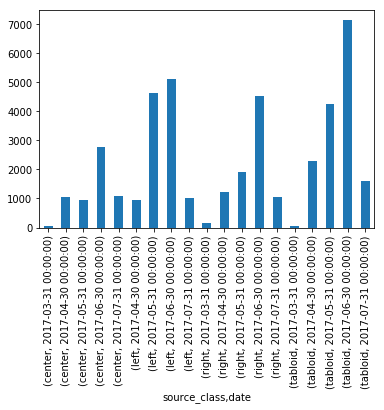

In [45]:
plt.show()

I think what we're mostly seeing here is that our scraper was most active during the month of June. 

Let's see the same distribution for provider.

In [46]:
deduped_date_idx['2017-03-01':'2017-07-07'].groupby(['provider']).resample('M').size().plot(kind='bar')

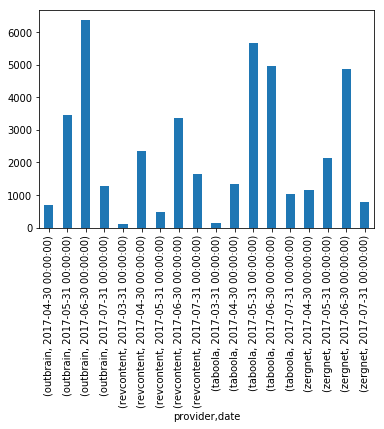

In [47]:
plt.show()

Same, we're seeing that our results are biased towards June.

What about if we check all results mentioning certain people

In [48]:
(deduped_date_idx[deduped_date_idx['headline'].str.contains('Trump')]['2017-03-01':'2017-07-07']).groupby('source_class').resample('M').size().plot(title="Headlines Containing 'Trump' By Month and Classification", kind='bar', color="pink")

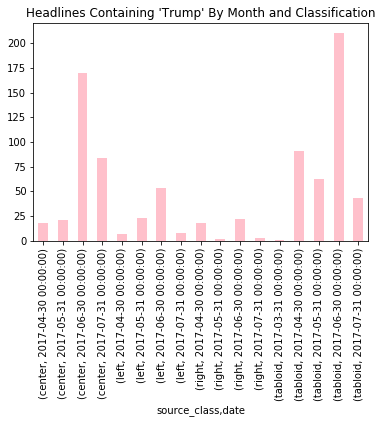

In [49]:
plt.show()

In [50]:
(deduped_date_idx[deduped_date_idx['headline'].str.contains('Clinton')]['2017-03-01':'2017-07-07']).groupby('source_class').resample('M').size().plot(title="Headlines Containing 'Clinton' By Month and Classification", kind='bar', color="gray")

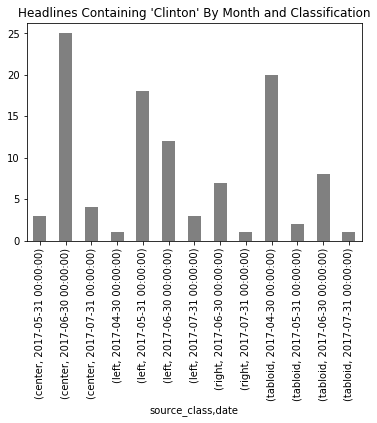

In [51]:
plt.show()

In [52]:
(deduped_date_idx[deduped_date_idx['headline'].str.contains('Hillary')]['2017-03-01':'2017-07-07']).groupby('source_class').resample('M').size().plot(title="Headlines Containing 'Hillary' By Month and Classification" ,kind='bar', color="gray")

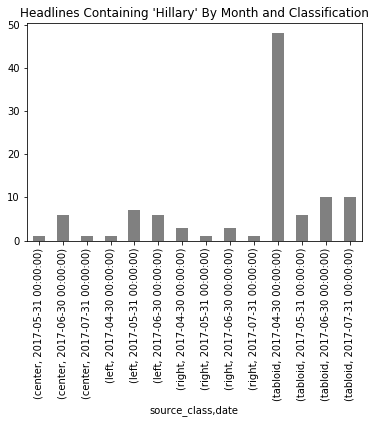

In [53]:
plt.show()

In [54]:
(deduped_date_idx[deduped_date_idx['headline'].str.contains('Obama')]['2017-03-01':'2017-07-07']).groupby('source_class').resample('M').size().plot(title="Headlines Containing 'Obama' By Month and Classification", kind='bar')

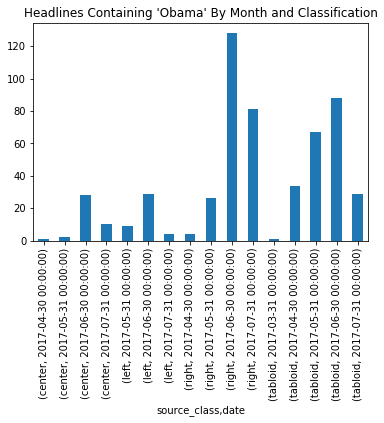

In [55]:
plt.show()

Again, seeing more of a trend around our data collection. There is an interesting trend that Trump articles are appearing on way more Tabloid articles than we might expect. Obama is appearing a lot on Right classified site articles, but again this is for June, so might just be an artifact of increased data collection. Finally, we see way more results for "Hillary" than we do "Clinton", and most of those are on Tabloid sites in April. 

And let's check out some bucketed headline trends, both largest and smallest overall and for the various classifications.

In [56]:
(deduped_date_idx['2017-03-27':'2017-07-07'])['headline'].value_counts().nlargest(15)

Nicole Kidman's Yacht Is Far From You'd Expect                                                               348
Triple Your Accuracy With This Weird Shooting Technique Used By Seal Snipers                                 230
Here Is How You Upgrade To Business Class                                                                    227
Forget Social Security if you Own a Home (Do This)                                                           224
Stairlifts are disrupting the multi-billion dollar retirement home industry - keeping seniors independent    194
Tiger Woods' Yacht Is Far From You'd Expect                                                                  179
Watch Obama's Face at 0:33. This Leaked Video Will Destroy Obama's Legacy                                    164
New Jersey Landlines Get Replaced (But Not With Cell Phones)                                                 161
Best Senior Living Communities Of 2017! View Pricing Here & Compare                             

In [57]:
(deduped_date_idx['2017-03-27':'2017-07-07'])['headline'].value_counts().nsmallest(15)

23 Surprising Things ‘Brady Bunch’ Producers Hid From Fans                              1
Is Taking A Career Break The New Norm?                                                  1
20 Things 'M*A*S*H' Producers Hid From Fans                                             1
Why David Caruso Got Dumped By Hollywood                                                1
Only 1 In 50 Americans Can Name These Iconic Women. Can You?                            1
Learn the Story Behind this Famous POTUS Picture                                        1
Beyonce's Most Iconic Beauty Moments of All Time                                        1
20 Wealthy Celebs Refuse to Help Their Poor Family                                      1
What 770,000 Tubes of Saliva Reveal…                                                    1
Meet The Worlds Most Powerful Leaders                                                   1
New Jersey Homeowners Use New Incentives to…                                            1
How Home C

In [58]:
deduped['headline'][deduped['source_class'].isin(['center'])].value_counts().nlargest(25)

27 Stars Who Died And Not a Word Was Said                                           91
21 Celebrities Who Died And Not a Word Was Said                                     90
Men, Eliminate Your ED (Do This Once Daily)                                         90
Remember Hurley? What He Looks Like Today Is Unreal                                 75
She Never Mentions Her Other Daughter, Here's Why                                   74
Here Is How You Upgrade To Business Class                                           70
Celebs Who Died And No One Said A Word                                              68
How to Fix Cracked Feet                                                             67
Forget Social Security if you Own a Home (Do This)                                  63
He Never Mentions His Daughter - Here Is Why                                        52
We Can Guess Your Education Level with Just 10 Questions                            46
#1 Tinnitus "Trick" to Stop the Ringing (Do

In [59]:
deduped['headline'][deduped['source_class'].isin(['center'])].value_counts().nsmallest(25)

Man Fulfils His Dying Fathers Crazy Wish                                   1
Don’t be the last of your friends in debt                                  1
"The sheets were baby-soft right out of the box"                           1
10 States That Would Get "Most Educated" in the Yearbook                   1
FBI employees wear ‘Comey is my homey’…                                    1
Unlimited 1.5% Cash Back Plus No Interest For 15 months Makes…             1
29 Colleges with the Biggest Decrease in Applications                      1
Huckabee Sanders: 'Republicans are going…                                  1
Congress has the ability to build a better air…                            1
Iowa GOP chairman calls Republican senator 'an…                            1
Watch Israel TV News Online                                                1
The Most Luxurious Sheets You Didn't Know You Needed                       1
Dems see surge of new candidates                                           1

In [60]:
deduped['headline'][deduped['source_class'].isin(['left'])].value_counts().nlargest(25)

Stairlifts are disrupting the multi-billion dollar retirement home industry - keeping seniors independent    173
Forget Social Security if you Own a Home (Do This)                                                           168
Here Is How You Upgrade To Business Class                                                                    157
Best Senior Living Communities Of 2017! View Pricing Here & Compare                                          109
Forget Social Security if you Own a Home (Do…                                                                 83
Thinking About Installing Solar Panels? Read This First                                                       65
Eddie Murphy's House Is Far From What You'd Expect                                                            63
The Most Common Cancer Symptoms People Ignore                                                                 55
Forget Social Security if you Own a Home…                                                       

In [61]:
deduped['headline'][deduped['source_class'].isin(['left'])].value_counts().nsmallest(25)

Hawking Reveals Shocking Prediction That Could Change Humanity – Daily                                     1
Tractor Supply Reveals the Truth About Chickens                                                            1
Nicole Richie And Joel Madden Finally Reveal Their Gorgeous Home                                           1
Get Monday's Best Friends & Family Deals on Ladies' Lingerie                                               1
The Definitive WWII Planes Quiz: Can You Ace It?                                                           1
F 22 Raptor Does Things Scientists Can't Figure…                                                           1
Scrutiny of Jared Kushner's Russia…                                                                        1
We Tested Nutrisystem: Here's What Happened                                                                1
Missing Disney Worker Disappears. Cops Uncover Truth                                                       1
7 Reasons Seniors S

In [62]:
deduped['headline'][deduped['source_class'].isin(['right'])].value_counts().nlargest(25)

Nicole Kidman's Yacht Is Far From You'd Expect                                      365
Tiger Woods' Yacht Is Far From You'd Expect                                         140
Watch Obama's Face at 0:33. This Leaked Video Will Destroy Obama's Legacy           138
We Can Guess Your Education Level with Only 10 Questions                            132
Triple Your Accuracy With This Weird Shooting Technique Used By Seal Snipers        123
Born Before 1969? You Could Get an Extra $2,194 Monthly with This                   105
Goldman Sachs & World Bank Confirm: Us Dollar Will Be Worthless in 100 Days         103
Search For The Best New Pickup Truck                                                 92
Hemp Company Releases Legal CBD Oil Across All 50 States                             83
This Is The Shopping Site Amazon Doesn't Want You To Know About                      75
He Never Mentions His Son, Here's Why                                                73
Exclusive: Massive US Invasion o

In [63]:
deduped['headline'][deduped['source_class'].isin(['right'])].value_counts().nsmallest(25)

Scary Common Signs of Pancreatic Cancer                                            1
Most Fearless Warriors That Existed Throughout History                             1
Is Networking And Partnering The Hardest Part Of Your Job?                         1
12 Must-Do Experiences in Las Vegas                                                1
Learn to Identify the Black Widow, Brown Recluse and Aggressive House Spider       1
10 Dangerous Secrets About Vitamins and Supplements                                1
Steve Mnuchin in 60 seconds                                                        1
Photos Captured During World War II Reveal...                                      1
21 Life Hacks To Create Healthy and Happy Lifestyle                                1
40 Futuristic Warships You Had No Idea Existed                                     1
This Place Is So Forbidden Most Didn't Even Know It Exists                         1
Man Discovers A Huge Secret In His Own Yard                      

In [64]:
deduped['headline'][deduped['source_class'].isin(['tabloid'])].value_counts().nlargest(25)

28 Pictures That Show How Crazy Woodstock 1969 Was                              139
Triple Your Accuracy With This Weird Shooting Technique Used By Seal Snipers    137
Kim Kardashian and North West Turn Heads On The Red Carpet                      126
Trump Voters Shocked After Watching This Leaked Video                           125
10 Surprising Things Guys Find Unattractive                                     114
9 Hair Mistakes That Make You Look Older                                        100
What Tiger Woods' Ex-Wife Looks Like Now Left Us With No Words                  100
10 Features That Attract Men The Most                                            97
After Losing 220lbs Rebel Wilson Is Gorgeous Now!                                96
10 Tricks To Always Look Good In Pictures                                        95
Anthony Bourdain Relieved to No Longer Pretend About Marriage                    87
New Pics Show Malia Obama Locking Arms With Gorgeous Guy                    

In [65]:
deduped['headline'][deduped['source_class'].isin(['tabloid'])].value_counts().nsmallest(25)

Kelly Osbourne Gives Update on Her Parents' Relationship                                                                1
Find All The  Accessories You'll Need To Own At Bal Harbour Shops                                                       1
Zendaya Lost it After Rihanna Shouted Out Her Met Gala Look                                                             1
44 Never Before Seen Photos of Famous People                                                                            1
Tom Cruise's $59 Million Mansion Will Take Your Breath Away                                                             1
Remember Her? What Rachel Ray Looks Like Now Will Shock You                                                             1
27 Sports Photos Taken at Just the Right Time                                                                           1
In 1920 Two Feral Girls Were Found Alone In The Jungle And Raised by Wolves. Their Story Will Leave You In Disbelief    1
Top 10 Most Beautiful La

Finally, we wanted to see if any headlines had more than one image. Let's check a few.

In [66]:
def imgs_from_headlines(headline):
    """
    A function to spit out all the different images used for a headline, assuming there's no more than 50/headline
    """
    all_images = deduped['img'][deduped['headline'].isin([headline])].value_counts().nlargest(50).index.tolist()
    for i in all_images:
        displaystring = '<img src={} width="200"/>'.format(i)
        display(HTML(displaystring))

In [67]:
imgs_from_headlines("Trump Voters Shocked After Watching This Leaked Video")

In [68]:
imgs_from_headlines("What Tiger Woods' Ex-Wife Looks Like Now Left Us With No Words")

In [69]:
imgs_from_headlines("Nicole Kidman's Yacht Is Far From You'd Expect")

In [70]:
imgs_from_headlines("He Never Mentions His Son, Here's Why")

In [71]:
imgs_from_headlines("Do This Tonight to Make Fungus Disappear by Morning (Try Today)")

Well, that was edifying. 

### Export the data

In [72]:
timestamp = datetime.now().strftime('%Y-%m-%d-%H_%M')

In [73]:
datefile = '../data/out/{}_native_ad_data_deduped.csv'.format(timestamp)

In [74]:
deduped.to_csv(datefile, index=False)

Finally, let's generate a json file where each item is an individual image, and for each image we are listing out all the original sources, dates, headlines, classifications, and final locations for it. 

In [75]:
img_json_data = {}
for index, row in deduped.iterrows():
    img_json_data[row['img_file']] = {'url':row['img'],
                                 'dates':[],
                                 'sources':[],
                                 'providers':[],
                                 'classifications':[],
                                 'headlines':[],
                                 'locations':[],
                                 }

In [76]:
print(len(img_json_data.keys()))

19314


In [77]:
for index, row in deduped.iterrows():
    record = img_json_data[row['img_file']]
    if row['date'] not in record['dates']:  
        record['dates'].append(row['date'])
    if row['headline'] not in record['headlines']:
        record['headlines'].append(row['headline'])
    if row['provider'] not in record['providers']:
        record['providers'].append(row['provider'])
    if row['source_class'] not in record['classifications']:
        record['classifications'].append(row['source_class'])
    if row['source'] not in record['sources']:
        record['sources'].append(row['source'])
    if row['final_link'] not in record['locations']:    
        record['locations'].append(row['final_link'])

In [78]:
for i in list(img_json_data.keys())[0:5]:
    print(img_json_data[i])

{'url': 'https://console.brax-cdn.com/creatives/98c6400e-f2fc-4c28-8e00-6c45914e36d5/TB15_1b309a68a23702cb95e743cea5d60029.600x500.png', 'dates': ['2017-03-27T12:59:09.279Z'], 'sources': ['http://tmz.com'], 'providers': ['taboola'], 'classifications': ['tabloid'], 'headlines': ['20 Cool Moments From Joe Biden’s Time In Office'], 'locations': ['http://scribol.com/a/news-and-politics/ways-joe-biden-made-vice-presidency-cool-again-americas-uncle/?utm_source=Taboola&utm_medium=CPC&utm_campaign=Joe_Biden_Cool_VP_US_Desktop&utm_content=tmz']}
{'url': 'http://cdn.taboolasyndication.com/libtrc/static/thumbnails/b13e719e4aff1daf7284c9bdb61e65a1.png', 'dates': ['2017-03-27T12:59:13.038Z'], 'sources': ['http://tmz.com'], 'providers': ['taboola'], 'classifications': ['tabloid'], 'headlines': ["25 Pics Donald Trump Doesn't Want You To See"], 'locations': ['http://detonate.com/pictures-that-trump-would-rather-keep-secret/?utm_source=8b4&utm_campaign=8b4_US_desktop_Trump_12_54f7_20160725_mm_3407&utm_

In [79]:
hl_json_data = {}
for index, row in deduped.iterrows():
    hl_json_data[row['headline']] = {'img_urls':[],
                                 'dates':[],
                                 'sources':[],
                                 'providers':[],
                                 'classifications':[],
                                 'imgs':[],
                                 'locations':[],
                                 }

In [80]:
print(len(hl_json_data.keys()))

15219


In [81]:
for index, row in deduped.iterrows():
    record = hl_json_data[row['headline']]
    if row['img'] not in record['img_urls']:
        record['img_urls'].append(row['img'])
    if row['date'] not in record['dates']:  
        record['dates'].append(row['date'])
    if row['img_file'] not in record['imgs']:
        record['imgs'].append(row['img_file'])
    if row['provider'] not in record['providers']:
        record['providers'].append(row['provider'])
    if row['source_class'] not in record['classifications']:
        record['classifications'].append(row['source_class'])
    if row['source'] not in record['sources']:
        record['sources'].append(row['source'])
    if row['final_link'] not in record['locations']:    
        record['locations'].append(row['final_link'])

In [82]:
for i in list(hl_json_data.keys())[0:5]:
    print(i, " = " ,hl_json_data[i])

20 Cool Moments From Joe Biden’s Time In Office  =  {'img_urls': ['https://console.brax-cdn.com/creatives/98c6400e-f2fc-4c28-8e00-6c45914e36d5/TB15_1b309a68a23702cb95e743cea5d60029.600x500.png'], 'dates': ['2017-03-27T12:59:09.279Z'], 'sources': ['http://tmz.com'], 'providers': ['taboola'], 'classifications': ['tabloid'], 'imgs': ['876aa5e83f6fb81a81908db3c02fdcc00d444000.png'], 'locations': ['http://scribol.com/a/news-and-politics/ways-joe-biden-made-vice-presidency-cool-again-americas-uncle/?utm_source=Taboola&utm_medium=CPC&utm_campaign=Joe_Biden_Cool_VP_US_Desktop&utm_content=tmz']}
25 Pics Donald Trump Doesn't Want You To See  =  {'img_urls': ['http://cdn.taboolasyndication.com/libtrc/static/thumbnails/b13e719e4aff1daf7284c9bdb61e65a1.png'], 'dates': ['2017-03-27T12:59:13.038Z'], 'sources': ['http://tmz.com'], 'providers': ['taboola'], 'classifications': ['tabloid'], 'imgs': ['d3a3f2f50c84529c08bb8314ae3aa66280f0cbc7.png'], 'locations': ['http://detonate.com/pictures-that-trump-wo

In [83]:
def to_json_file(json_data, prefix):
    filename = "../data/out/{}_grouped_data.json".format(prefix)
    with open(filename, 'w') as outfile:
        json.dump(json_data, outfile, indent=4)

In [84]:
to_json_file(img_json_data, "images")

In [85]:
to_json_file(hl_json_data, "headlines")